<h2>Here we make a single table with all the merged data, drop or replace N/A, convert units etc.</h2>
I believe that some data preprocessing steps should be model-specific, so until we are done with model selection, I am trying to be conservative with preprocessing

In [251]:
from os import listdir
from os.path import isfile, join
from tqdm.notebook import tqdm

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [252]:
# Cool one-liner by pycruft on stackoverflow
# https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

path = "saved_tables"

files = [f for f in listdir(path) if isfile(join(path, f))]

In [253]:
data = pd.DataFrame()

for file in tqdm(files, desc="Merging File"):
    table = pd.read_csv(join(path, file), index_col=0) # Read from file
    
    # The scraped tables feature a number of rows filled with NaNs in the end for some reason - here we get rid of them
    table = table.dropna(how="all") 
    
    table.insert(0, "Date", file[:-4]) # BAD - I don't like in-place operations
    data = pd.concat((data, table)) # Append to the resulting dataframe

Merging File:   0%|          | 0/3619 [00:00<?, ?it/s]

For feature engineering purposes, I don't want to replace neither date nor time with datetime. Keeping the date column allows to formulate the question "Will it rain tomorrow" more easily and the time column might be essential for predictions because it keeps information on the phase in it. Might also be important to add sunset and sunrise info later.

So, here I just make sure that date and time are in their appropriate formats and add datetime as a separate column.

In [254]:
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d")

# I could use to_datetime and to_timedelta, but in my case this is more elegant:

# Split on : or whitespace (before AM/PM)
hrs, mins, AM_PM = data["Time"].str.split(":|\s", n=2, expand=True).values.T

PM = (AM_PM == "PM").astype(int)
AM12 = (hrs != "12").astype(int) # Mathematically, 12:30 PM is actually 12:30 AM

# Convert into minutes. Multiplying by AM12 prevents adding 12 hours to times like 12:30 PM.
mins_into_day = PM * 12 * 60 * AM12 + hrs.astype(int) * 60 + mins.astype(int)
data.insert(0, "mins_into_day", value=mins_into_day)

Convert temperature and dew point to Kelvin

In [255]:
F = data["Temperature"].str.split(expand=True).values.T[0].astype(float)
K = (F - 32) * 5 / 9 + 273.15
data.insert(3, column="Temp, K", value=K)

F = data["Dew Point"].str.split(expand=True).values.T[0].astype(float)
K = (F - 32) * 5 / 9 + 273.15
data.insert(5, column="Dew Point, K", value=K)

Convert wind speed to m/s. Wind Gust is ignored because it is reported as always at 0.

In [256]:
data["Wind Speed, m/s"] = data["Wind Speed"].str.split(expand=True).values.T[0].astype(float) * 0.44704

Format humidity

In [257]:
data["Humidity"] = data["Humidity"].str.split(expand=True).values.T[0].astype(float)

Convert pressure to pascals

In [258]:
data["Pressure, Pa"] = data["Pressure"].str.split(expand=True).values.T[0].astype(float) * 3386.39

Ordinally encode condition

In [259]:
data["Condition"].unique()

array(['Fair', 'Partly Cloudy', 'Mostly Cloudy', 'Drizzle', 'Light Rain',
       'Rain', 'Thunder / Wintry Mix', 'Light Rain with Thunder',
       'Patches of Fog', 'Fair / Windy', 'Mostly Cloudy / Windy',
       'Rain / Windy', 'Thunder', 'T-Storm', 'Rain and Sleet',
       'Thunder in the Vicinity', 'Thunder / Wintry Mix / Windy',
       'Hail / Windy', 'Heavy Rain', 'Cloudy', 'Mist', 'Haze',
       'Widespread Dust', 'Heavy Rain Shower', 'Heavy T-Storm',
       'Patches of Fog / Windy', 'Partly Cloudy / Windy',
       'Thunder / Windy', 'T-Storm / Windy', 'Light Rain / Windy',
       'Rain Shower', 'Hail', 'Widespread Dust / Windy',
       'Rain Shower / Windy', 'Rain and Sleet / Windy',
       'Thunder and Hail', 'Fog', 'Duststorm', 'Duststorm / Windy',
       'Heavy Rain / Windy', 'Showers in the Vicinity',
       'Heavy T-Storm / Windy', 'Haze / Windy', 'Light Drizzle'],
      dtype=object)

In [9]:
ord_mapping = {"Fair": 0, "Partly Cloudy": 1, "Mostly Cloudy": 2}
data["condition_ord"] = data["Condition"].map(ord_mapping)

Convert wind direction to azimuth; if it is marked as "VAR", then set the value to -1 and later replace wind speed with 0 in such cases. It would make physical sense that if the wind direction was truly variating so much that not a single direction could be determined, then its average speed over the hour probably cancels out to 0.

In [10]:
az_mapping = {"N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
             "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
             "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
             "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5,
             "VAR": -1}
data["Wind"] = data["Wind"].map(az_mapping).astype(float)

In [66]:
data

,mins_into_day,Date,Time,"Temp, K",Temperature,"Dew Point, K",Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,"Wind Speed, m/s","Pressure, Pa",condition_ord
0,410,2015-01-01,6:50 AM,285.927778,55 °F,278.150000,41 °F,58.0,157.5,7 °mph,0 °mph,29.97 °in,0.0 °in,Fair,3.12928,101490.1083,0.0
1,470,2015-01-01,7:50 AM,285.927778,55 °F,278.150000,41 °F,58.0,157.5,7 °mph,0 °mph,30.00 °in,0.0 °in,Fair,3.12928,101591.7000,0.0
2,530,2015-01-01,8:50 AM,288.150000,59 °F,279.261111,43 °F,55.0,112.5,6 °mph,0 °mph,30.03 °in,0.0 °in,Fair,2.68224,101693.2917,0.0
3,590,2015-01-01,9:50 AM,292.038889,66 °F,279.261111,43 °F,43.0,-1.0,3 °mph,0 °mph,30.06 °in,0.0 °in,Fair,1.34112,101794.8834,0.0
4,650,2015-01-01,10:50 AM,294.261111,70 °F,275.927778,37 °F,31.0,-1.0,2 °mph,0 °mph,30.03 °in,0.0 °in,Fair,0.89408,101693.2917,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,890,2024-12-20,2:50 PM,292.038889,66 °F,284.261111,52 °F,60.0,247.5,6 °mph,0 °mph,29.91 °in,0.0 °in,Fair,2.68224,101286.9249,0.0
12,950,2024-12-20,3:50 PM,292.038889,66 °F,282.038889,48 °F,52.0,270.0,5 °mph,0 °mph,29.94 °in,0.0 °in,Fair,2.23520,101388.5166,0.0
13,1010,2024-12-20,4:50 PM,290.927778,64 °F,284.261111,52 °F,64.0,-1.0,2 °mph,0 °mph,29.94 °in,0.0 °in,Fair,0.89408,101388.5166,0.0
14,1070,2024-12-20,5:50 PM,290.372222,63 °F,285.372222,54 °F,72.0,-1.0,3 °mph,0 °mph,29.97 °in,0.0 °in,Fair,1.34112,101490.1083,0.0


Let's clean up the table, get rid of unneeded columns, rearrange the needed ones a bit.

In [12]:
data_clean = data.drop(columns=["Time", "Temperature", "Dew Point", "Humidity", "Wind Speed", "Wind Gust", "Pressure", "Precip.", "Condition"])

In [13]:
start_of_day = data_clean.groupby("Date").agg({"mins_into_day": ["min"]}).values

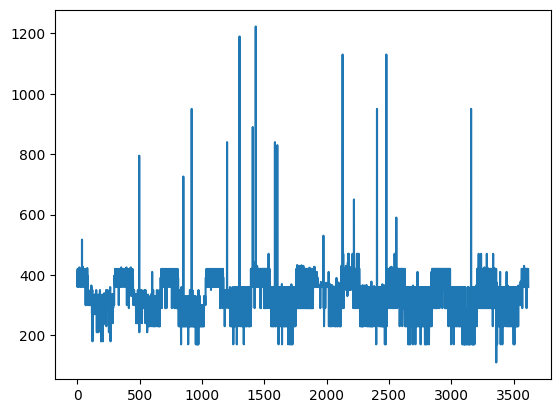

In [20]:
plt.plot(start_of_day)
plt.show()

We can clearly see DST in this graph. Let's adjust for it manually.

In [21]:
DST_list = [["27-03-2015", "25-10-2015"],
           ["25-03-2016", "30-10-2016"],
           ["24-03-2017", "29-10-2017"],
           ["23-03-2018", "28-10-2018"],
           ["29-03-2019", "27-10-2019"],
           ["27-03-2020", "25-10-2020"],
           ["26-03-2021", "31-10-2021"],
           ["25-03-2022", "30-10-2022"],
           ["24-03-2023", "29-10-2023"],
           ["29-03-2024", "27-10-2024"]]

I don't like this, I should generate it automatically. #TODO

In [25]:
data_DST_corrected = data_clean.copy()

for start, end in DST_list:
    start_mask = data_clean.Date >= start
    end_mask = data_clean.Date <= end
    data_DST_corrected.loc[start_mask & end_mask, "mins_into_day"] = data_DST_corrected[start_mask & end_mask]["mins_into_day"].add(60)

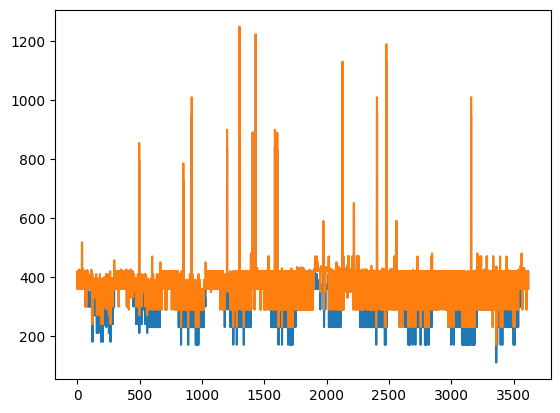

In [26]:
start_of_day = data_clean.groupby("Date").agg({"mins_into_day": ["min"]}).values
start_of_day_DST_corrected = data_DST_corrected.groupby("Date").agg({"mins_into_day": ["min"]}).values
plt.plot(start_of_day)
plt.plot(start_of_day_DST_corrected)
plt.show()

The next step is to merge with the rain data. 

<h3>A file from the Israeli Meteorological Service</h3>

This covers dates from Dec 1st 2021 through Dec 20th 2024.

In [107]:
ims_rain = pd.read_csv("data/data_202412211441.csv")

These next 2 files cover the timeframe from 2012 up to Nov 30 2021 from the Refineries and the Technion meteorological stations

In [41]:
ref_rain = pd.read_csv("data/haifa_ref-01012012_30112021.csv")
technion_rain = pd.read_csv("data/haifa-technion_31012009_30112021.csv")

We are mainly interested in predicting rain "the next day", so let's check how well the data from these two stations agrees in terms of "has it rained today". Also, since the data scraped from wunderground only covers daytime, let's check if the same is true for rain.

First things first, let's convert date and time to the same format as the rest of the data.

In [182]:
hrs, mins, _ = ref_rain["Time"].str.split(":|\s", n=2, expand=True).values.T
mins_into_day = hrs.astype(int) * 60 + mins.astype(int)
ref_rain["mins_into_day"] = mins_into_day
ref_rain["Date"] = pd.to_datetime(ref_rain["Date"], format="%d/%m/%Y")

hrs, mins, _ = technion_rain["Time"].str.split(":|\s", n=2, expand=True).values.T
mins_into_day = hrs.astype(int) * 60 + mins.astype(int)
technion_rain["mins_into_day"] = mins_into_day
technion_rain["Date"] = pd.to_datetime(technion_rain["Date"], format="%d/%m/%Y")

refineries_rainy_days = ref_rain.Date.unique()
technion_rainy_days = technion_rain.Date.unique()

print("ref total: ", len(refineries_rainy_days))
print("tech total: ", len(technion_rainy_days))
print("ref - tech: ", len(set(refineries_rainy_days) - set(technion_rainy_days)))
print("tech - ref: ", len(set(technion_rainy_days) - set(refineries_rainy_days)))

ref total:  633
tech total:  822
ref - tech:  63
tech - ref:  252


It seems that the rain events were significantly different at the Technion and at the Refineries. Since the weather data comes from the Haifa Airport, that is closer to the Refineries and at a similar elevation, I will disregard the Technion rain data for now. Let's select only the refineries data from ims_rain and merge it with the ref_rain

<h2>Post 2021 data</h2>

In [184]:
ims_rain = pd.read_csv("data/data_202412211441.csv")

ims_rain.loc[ims_rain["Rain Correction (mm)"] == "-", "Rain Correction (mm)"] = -1
ims_rain["Rain Correction (mm)"] = ims_rain["Rain Correction (mm)"].astype(float)
ims_rain.loc[ims_rain["Rain Correction (mm)"] != -1, "Rainfall per minute (mm)"] = ims_rain["Rain Correction (mm)"]
ims_rain["rain"] = ims_rain["Rainfall per minute (mm)"]

In [185]:
ims_rain["datetime"] = pd.to_datetime(ims_rain["Date & Time (Winter)"], format = "%d/%m/%Y %H:%M")
ims_rain["date"] = ims_rain.datetime.dt.date
ims_rain["time"] = ims_rain.datetime.dt.time

hrs, mins, _ = ims_rain["time"].astype(str).str.split(":|\s", n=2, expand=True).values.T
mins_into_day = hrs.astype(int) * 60 + mins.astype(int)
ims_rain["mins_into_day"] = mins_into_day
ims_rain.date = pd.to_datetime(ims_rain.date)

In [186]:
ims_rain = ims_rain[ims_rain["Station"] == "Haifa Refineries_1m"]
daily_rain_post_2021 = ims_rain.groupby("date").agg({"rain":"sum"})

<h2>Pre-2021</h2>

In [208]:
ref_rain["rain"] = ref_rain["Calibrated Rain (mm/1min)"]
daily_rain_pre_2021 = ref_rain.groupby("Date").agg({"rain":"sum"})

<h1>Merging</h1>

In [248]:
daily_rain_post_2021.index = daily_rain_post_2021.index.rename("Date")
daily_rain = pd.concat((daily_rain_pre_2021, daily_rain_post_2021))

In [249]:
data = data_DST_corrected.merge(right=daily_rain, on="Date", how="left")
data.loc[data["rain"].isna(), "rain"] = 0

In [261]:
data.to_csv("preprocessed_data.csv")